C:\Users\IvanSukhanov\AppData\Local\Temp\ipykernel_7948\3276522984.py:44: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  train_data = train_data.asfreq('H')
C:\Users\IvanSukhanov\AppData\Local\Temp\ipykernel_7948\3276522984.py:45: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  test_data = test_data.asfreq('H')
C:\Users\IvanSukhanov\AppData\Local\Temp\ipykernel_7948\3276522984.py:48: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object

SARIMA Model MAE: 0.41267486785791313
SARIMAX Model MAE: 0.37525071953082767
SARIMA Model R2 Score: 0.00552802255995799
SARIMAX Model R2 Score: 0.14461013734949224


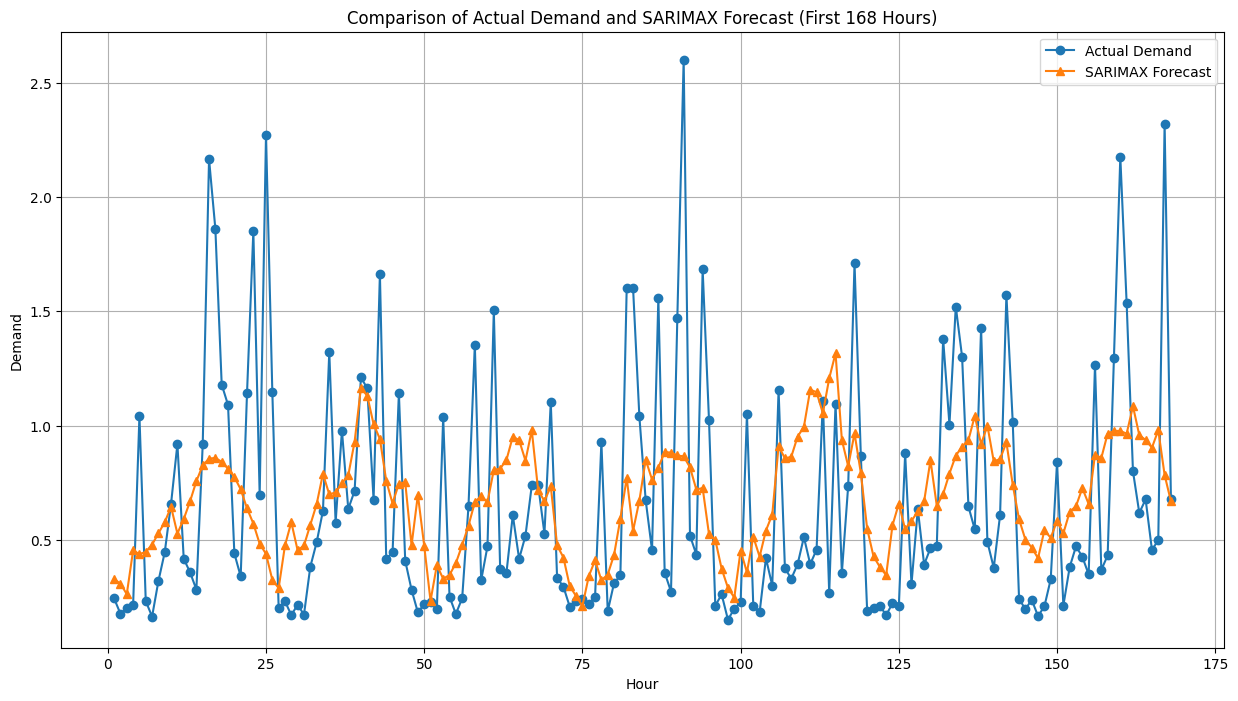

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# File paths
train_file_path = r"C:\Users\IvanSukhanov\Desktop\PhD\Classes\Energy\HW2\train.csv"
test_file_path = r"C:\Users\IvanSukhanov\Desktop\PhD\Classes\Energy\HW2\test.csv"

# Load datasets
train_data = pd.read_csv(train_file_path)
test_data = pd.read_csv(test_file_path)

# Reformat datetime column if necessary
datetime_column = 'datetime'
if datetime_column not in train_data.columns:
    datetime_column_train = train_data.columns[0]  # Assuming the first column is the datetime column
    train_data.rename(columns={datetime_column_train: 'datetime'}, inplace=True)

if datetime_column not in test_data.columns:
    datetime_column_test = test_data.columns[0]
    test_data.rename(columns={datetime_column_test: 'datetime'}, inplace=True)

# Convert 'datetime' column to string
train_data['datetime'] = train_data['datetime'].astype(str)
test_data['datetime'] = test_data['datetime'].astype(str)

# Parse 'datetime' column with proper format and time zone handling
train_data['datetime'] = pd.to_datetime(train_data['datetime'], format='%Y-%m-%d %H:%M:%S%z', errors='raise', utc=True)
test_data['datetime'] = pd.to_datetime(test_data['datetime'], format='%Y-%m-%d %H:%M:%S%z', errors='raise', utc=True)

# Remove time zone information
train_data['datetime'] = train_data['datetime'].dt.tz_localize(None)
test_data['datetime'] = test_data['datetime'].dt.tz_localize(None)

# Set datetime as index
train_data.set_index('datetime', inplace=True)
test_data.set_index('datetime', inplace=True)

# Ensure frequency information is provided
train_data = train_data.asfreq('H')
test_data = test_data.asfreq('H')

# Preprocess train and test datasets
train_data['snow'].fillna(0, inplace=True)
train_data['demand'].fillna(train_data['demand'].median(), inplace=True)

test_data['snow'].fillna(0, inplace=True)
test_data['demand'].fillna(test_data['demand'].median(), inplace=True)

# Create time features
def create_time_features(data):
    data['hour'] = data.index.hour
    data['day_of_week'] = data.index.dayofweek  # Monday=0, Sunday=6
    data['prev_day_same_hour_demand'] = data['demand'].shift(24)
    data['is_night'] = data['hour'].apply(lambda x: 1 if x >= 0 and x <= 6 else 0)
    # Fill missing values
    data['prev_day_same_hour_demand'].fillna(method='bfill', inplace=True)
    return data

train_data = create_time_features(train_data)
test_data = create_time_features(test_data)

# Cyclical encoding for 'hour' and 'day_of_week'
def cyclical_encoding(data):
    data['hour_sin'] = np.sin(2 * np.pi * data['hour'] / 24)
    data['hour_cos'] = np.cos(2 * np.pi * data['hour'] / 24)
    data['day_of_week_sin'] = np.sin(2 * np.pi * data['day_of_week'] / 7)
    data['day_of_week_cos'] = np.cos(2 * np.pi * data['day_of_week'] / 7)
    return data

train_data = cyclical_encoding(train_data)
test_data = cyclical_encoding(test_data)

# Update numerical columns
numerical_cols = ['temp', 'dwpt', 'price', 'prev_day_same_hour_demand', 'is_night',
                  'hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos']

# Standardize the dataset features
scaler = StandardScaler()
train_scaled = train_data.copy()
train_scaled[numerical_cols] = scaler.fit_transform(train_data[numerical_cols])

test_scaled = test_data.copy()
test_scaled[numerical_cols] = scaler.transform(test_data[numerical_cols])

# Separate exogenous features
exog_train = train_scaled[['temp', 'dwpt', 'price', 'prev_day_same_hour_demand', 'is_night',
                           'hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos']]

exog_test = test_scaled[['temp', 'dwpt', 'price', 'prev_day_same_hour_demand', 'is_night',
                         'hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos']]

# Combine exogenous features
exog_data = pd.concat([exog_train, exog_test])
exog_data.sort_index(inplace=True)

# Train SARIMA model based on last 2 months of train data
last_2_months = train_data.index.max() - pd.DateOffset(months=2)
train_subset = train_data[train_data.index >= last_2_months]

sarima_model = ARIMA(train_subset['demand'], order=(1, 1, 1))
sarima_fit = sarima_model.fit()

# Train SARIMAX model with additional inputs
exog_train_subset = exog_data.loc[train_subset.index]
sarimax_model = SARIMAX(train_subset['demand'], exog=exog_train_subset, order=(1, 1, 1))
sarimax_fit = sarimax_model.fit()

# Rolling out-of-sample forecast
sarima_forecasts = []
sarimax_forecasts = []
actuals = []

# Reset train_data to original (last 2 months)
train_data = train_data[train_data.index >= last_2_months]
exog_data = exog_data.loc[train_data.index]

for day in range(0, len(test_data), 24):  # Iterate day-by-day (24-hour blocks)
    # Actual data for the day
    actual_day = test_data['demand'].iloc[day:day + 24].values
    actuals.extend(actual_day)

    # SARIMA forecast
    sarima_forecast = sarima_fit.forecast(steps=24)
    sarima_forecasts.extend(sarima_forecast)

    # SARIMAX forecast
    exog_forecast = exog_test.iloc[day:day + 24].copy()

    # Handle NaNs and infinite values in exog_forecast
    exog_forecast.replace([np.inf, -np.inf], np.nan, inplace=True)
    exog_forecast.fillna(method='bfill', inplace=True)
    exog_forecast.fillna(method='ffill', inplace=True)
    exog_forecast.fillna(0, inplace=True)

    sarimax_forecast = sarimax_fit.forecast(steps=24, exog=exog_forecast)
    sarimax_forecasts.extend(sarimax_forecast)

    # Update models with actual data (adaptive with last 2 weeks of data)
    # Append the new data to train_data
    new_train_data = test_data.iloc[day:day + 24]
    train_data = pd.concat([train_data, new_train_data])
    train_data.sort_index(inplace=True)

    # Recreate features for the updated train_data
    train_data = create_time_features(train_data)
    train_data = cyclical_encoding(train_data)

    # Update and scale the new exogenous features
    new_exog_data = train_data[['temp', 'dwpt', 'price', 'prev_day_same_hour_demand', 'is_night',
                                'hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos']].iloc[-24:]

    # Scale numerical columns
    new_exog_data[numerical_cols] = scaler.transform(new_exog_data[numerical_cols])

    # Append to exog_data
    exog_data = pd.concat([exog_data, new_exog_data])
    exog_data.sort_index(inplace=True)

    # Keep only the last 2 weeks of data
    last_2_weeks = train_data.index.max() - pd.DateOffset(weeks=2)
    train_subset = train_data[train_data.index >= last_2_weeks]
    exog_train_subset = exog_data.loc[train_subset.index]

    # Handle NaNs and infinite values in exog_train_subset
    exog_train_subset.replace([np.inf, -np.inf], np.nan, inplace=True)
    exog_train_subset.fillna(method='bfill', inplace=True)
    exog_train_subset.fillna(method='ffill', inplace=True)
    exog_train_subset.fillna(0, inplace=True)

    # Refit the models
    sarima_fit = ARIMA(train_subset['demand'], order=(1, 1, 1)).fit()
    sarimax_fit = SARIMAX(train_subset['demand'], exog=exog_train_subset, order=(1, 1, 1)).fit()

# Calculate MAE for each model
mae_sarima = mean_absolute_error(actuals, sarima_forecasts)
mae_sarimax = mean_absolute_error(actuals, sarimax_forecasts)

# Calculate R2 scores for each model
r2_sarima = r2_score(actuals, sarima_forecasts)
r2_sarimax = r2_score(actuals, sarimax_forecasts)

# Display results
print("SARIMA Model MAE:", mae_sarima)
print("SARIMAX Model MAE:", mae_sarimax)
print("SARIMA Model R2 Score:", r2_sarima)
print("SARIMAX Model R2 Score:", r2_sarimax)

# Create a time index for the 168-hour forecast
time_index_168 = range(1, 169)  # Hours 1 to 168

# Plot the actual data and SARIMAX forecast for the 168-hour forecast period
plt.figure(figsize=(15, 8))
plt.plot(time_index_168, actuals[:168], label="Actual Demand", marker='o')
plt.plot(time_index_168, sarimax_forecasts[:168], label="SARIMAX Forecast", marker='^')

# Add labels, legend, and title
plt.xlabel("Hour")
plt.ylabel("Demand")
plt.title("Comparison of Actual Demand and SARIMAX Forecast (First 168 Hours)")
plt.legend()
plt.grid(True)
plt.show()
